In [1]:
import warnings
import os
import glob
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL
import torch
import torchvision

from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2

import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

from sklearn.model_selection import train_test_split

warnings.simplefilter('ignore')

In [2]:
import kagglehub

path = kagglehub.dataset_download("mateuszbuda/lgg-mri-segmentation")

print("Path to dataset files:", path)

100%|██████████| 714M/714M [00:34<00:00, 21.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mateuszbuda/lgg-mri-segmentation/versions/2


In [3]:
imgs = glob.glob(os.path.join(path, "kaggle_3m", "**", "*.tif"), recursive=True)
scan_imgs, mask_imgs = [], set()

for img in imgs:
    if "mask" in img:
        mask_imgs.add(img)
    else:
        scan_imgs.append(img)

imgs_map = [(img, img[:-4] + "_mask.tif") for img in scan_imgs if img[:-4] + "_mask.tif" in mask_imgs]

train_imgs, test_imgs = train_test_split(imgs_map, shuffle=True, test_size=0.2, random_state=42)
train_imgs, val_imgs = train_test_split(train_imgs, shuffle=True, test_size=0.2, random_state=42)

In [4]:
class ImageDataset(Dataset):
    def __init__(self, imgs_map, transforms=None, in_transforms=None, out_transforms=None):
        self.imgs_map = imgs_map
        self.transforms = transforms
        self.in_transforms = in_transforms
        self.out_transforms = out_transforms

    def __len__(self):
        return len(self.imgs_map)

    def __getitem__(self, idx):
        scan_path, mask_path = self.imgs_map[idx]
        scan = PIL.Image.open(scan_path).convert("RGB")
        mask = PIL.Image.open(mask_path).convert("L")

        if self.transforms:
            scan, mask = self.transforms(scan, mask)

        if self.in_transforms:
            scan = self.in_transforms(scan)

        if self.out_transforms:
            mask = self.out_transforms(mask)

        return scan, mask

In [5]:
def train(model, num_epochs, criterion, optimizer, trainloader, valloader=None, scheduler=None, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.view(outputs.shape))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch + 1}, Training Loss: {running_loss / len(trainloader)}")

        if valloader is not None:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for i, data in enumerate(valloader, 0):
                    inputs, labels = data
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels.view(outputs.shape))
                    val_loss += loss.item()
            print(f"Epoch {epoch + 1}, Validation Loss: {val_loss / len(valloader)}")

        if scheduler is not None:
            scheduler.step()

In [6]:
def test(model, testloader, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.view(outputs.shape))
            test_loss += loss.item()

    print(f"Test Loss: {test_loss / len(testloader)}")

In [7]:
def plot_results(model, sampleds, n_sample, threshold, detransform = None, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    model.eval()

    fig, axes = plt.subplots(n_sample, 3, figsize=(15, 30))

    for i in range(n_sample):
        image, mask = sampleds[i]
        image = image.unsqueeze(0).to(device)
        mask = mask.unsqueeze(0).to(device)

        with torch.no_grad():
            prediction = model(image)

        prediction = (prediction > threshold).float()
        predicted_image = prediction.cpu().view(mask.shape).squeeze().numpy()
        actual_image = mask.cpu().squeeze().numpy()
        scan_image = image.cpu().squeeze().numpy().transpose((1, 2, 0))

        if detransform is not None:
            scan_image = detransform(scan_image)


        axes[i, 0].imshow(scan_image)
        axes[i, 0].set_title("MRI Scan")

        axes[i, 1].imshow(actual_image, cmap='gray')
        axes[i, 1].set_title("Actual Mask")

        axes[i, 2].imshow(predicted_image, cmap='gray')
        axes[i, 2].set_title("Predicted Mask")

    plt.show()

### Resnet 50

In [8]:
gc.collect()
torch.cuda.empty_cache()

In [9]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])

transforms = v2.Compose([
    v2.ToImage(),
    v2.Resize((224, 224)),
    v2.ToTensor()
])

in_transforms = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean, std)
])

out_transforms = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
])

trainds = ImageDataset(train_imgs, transforms, in_transforms, out_transforms)
valds = ImageDataset(val_imgs, transforms, in_transforms, out_transforms)
testds = ImageDataset(test_imgs, transforms, in_transforms, out_transforms)

trainloader = DataLoader(trainds, batch_size=64, shuffle=True)
valloader = DataLoader(valds, batch_size=64, shuffle=False)
testloader = DataLoader(testds, batch_size=64, shuffle=False)

In [10]:
model = models.resnet50(pretrained=True)

# for param in model.parameters():
#     param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(2048, 224 * 224),
    nn.Sigmoid()
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.99))
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

num_epochs = 30

train(model, num_epochs, criterion, optimizer, trainloader, valloader, scheduler, device)
test(model, testloader, device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 222MB/s]


Epoch 1, Training Loss: 0.07127410294488072
Epoch 1, Validation Loss: 0.037420915067195894
Epoch 2, Training Loss: 0.03255872167646885
Epoch 2, Validation Loss: 0.03917037211358547
Epoch 3, Training Loss: 0.027637259941548108
Epoch 3, Validation Loss: 0.028409160487353802
Epoch 4, Training Loss: 0.02242981505114585
Epoch 4, Validation Loss: 0.022621649131178857
Epoch 5, Training Loss: 0.01847860619891435
Epoch 5, Validation Loss: 0.02118205465376377
Epoch 6, Training Loss: 0.016442905785515903
Epoch 6, Validation Loss: 0.017389000579714774
Epoch 7, Training Loss: 0.015142953651957215
Epoch 7, Validation Loss: 0.016400688886642457
Epoch 8, Training Loss: 0.013516190066002309
Epoch 8, Validation Loss: 0.014533137157559394
Epoch 9, Training Loss: 0.012928107543848455
Epoch 9, Validation Loss: 0.014216978382319213
Epoch 10, Training Loss: 0.01232848719228059
Epoch 10, Validation Loss: 0.01379481926560402
Epoch 11, Training Loss: 0.011600467807147652
Epoch 11, Validation Loss: 0.01343548009

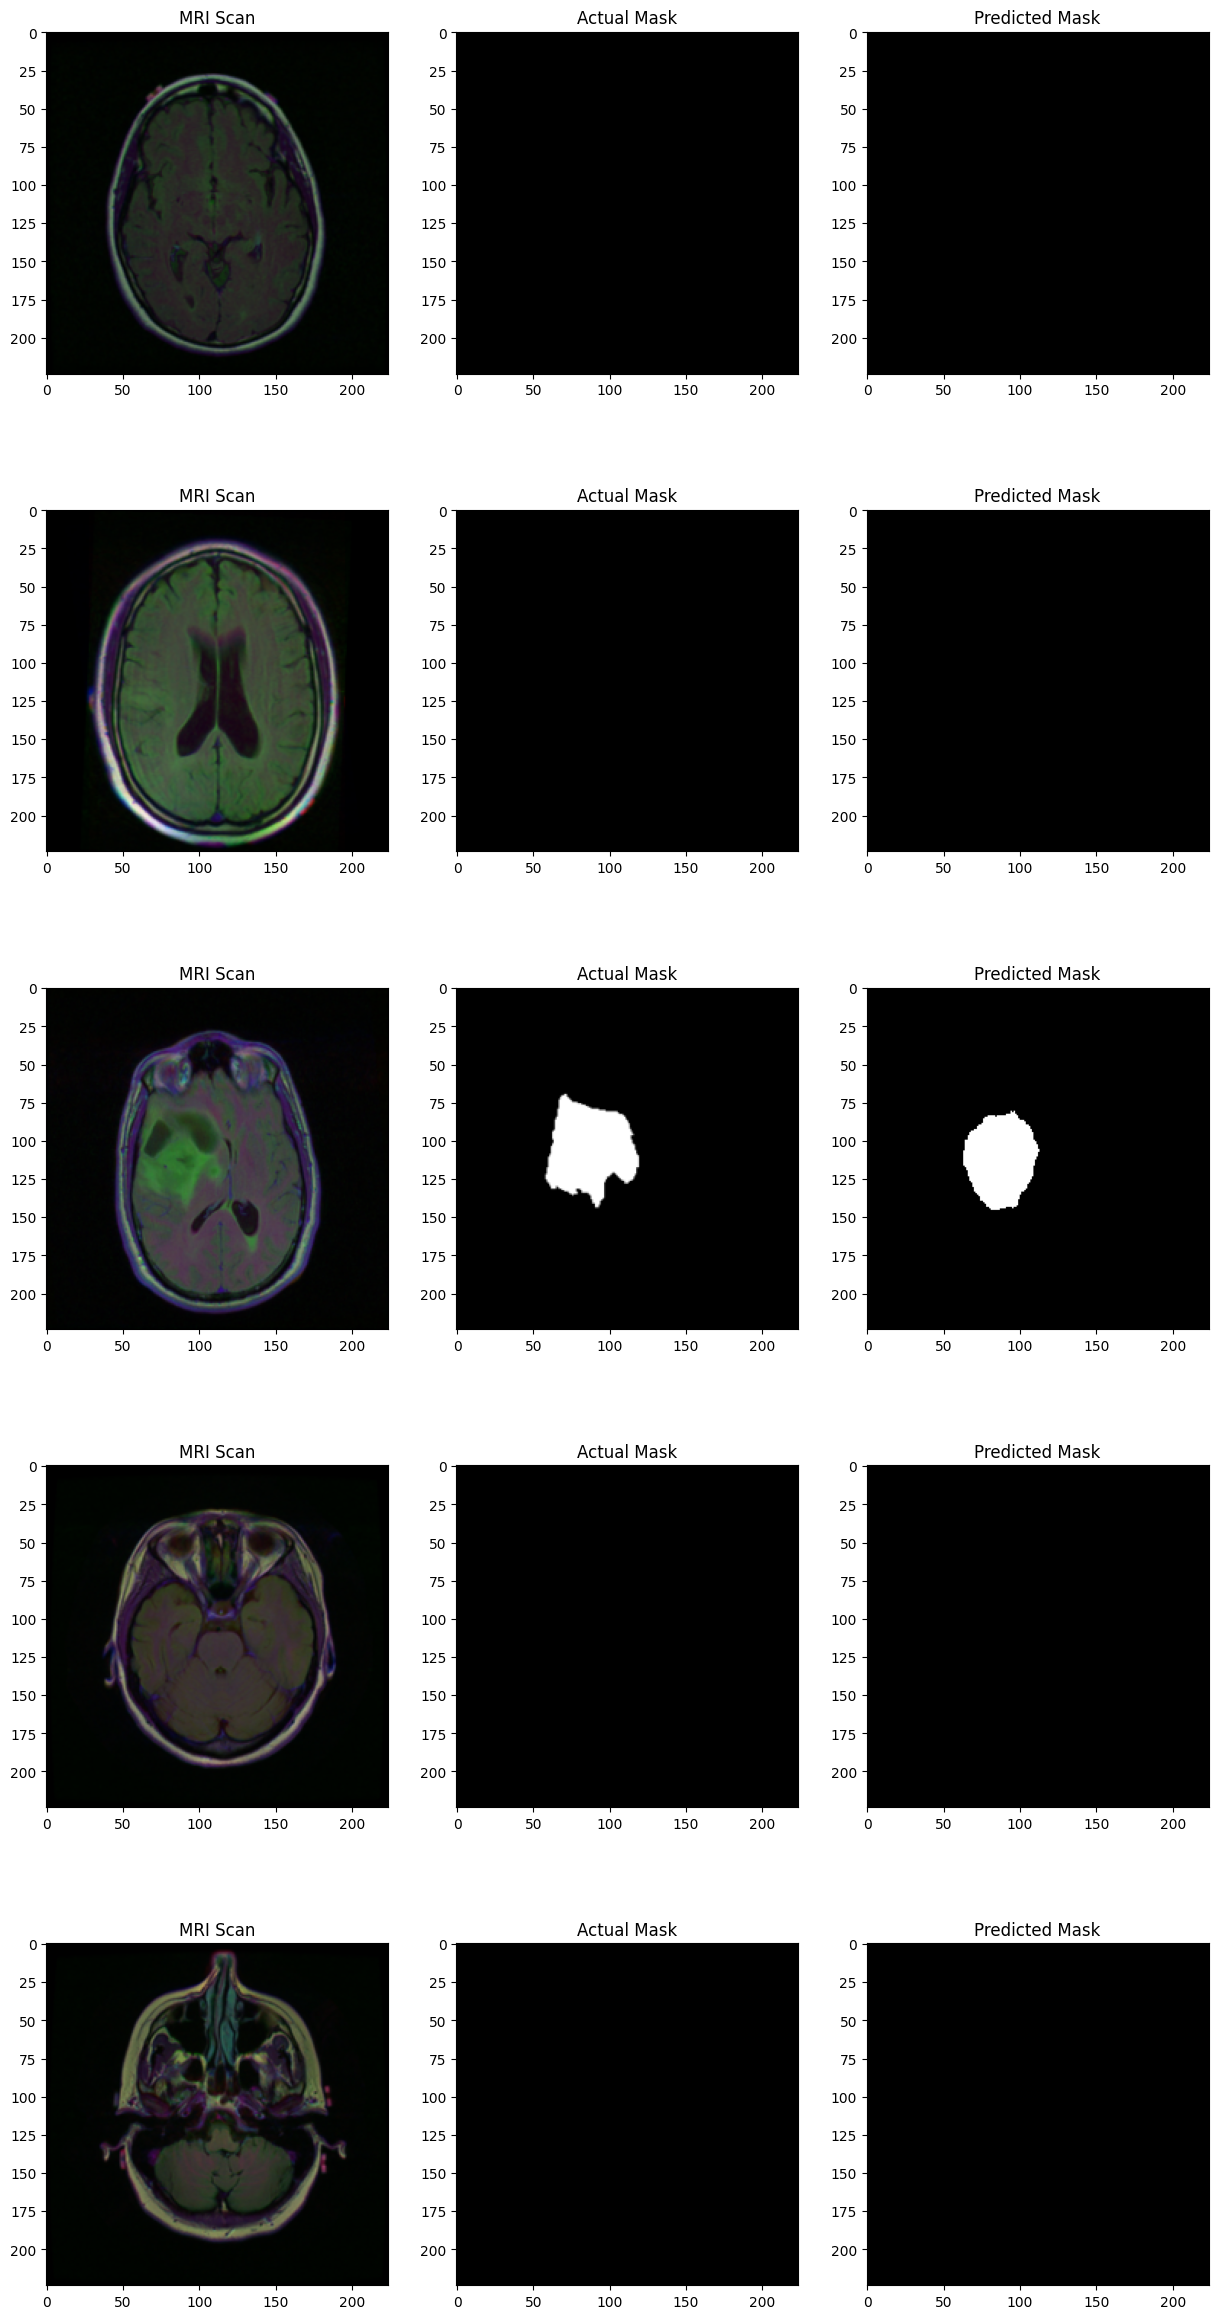

In [11]:
plot_results(model, testds, 5, 0.5, detransform=lambda x: x * std + mean, device=device)

### Efficientnet

In [12]:
gc.collect()
torch.cuda.empty_cache()

In [13]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])

transforms = v2.Compose([
    v2.ToImage(),
    v2.Resize((260, 260)),
    v2.ToTensor()
])

in_transforms = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean, std)
])

out_transforms = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
])

trainds = ImageDataset(train_imgs, transforms, in_transforms, out_transforms)
valds = ImageDataset(val_imgs, transforms, in_transforms, out_transforms)
testds = ImageDataset(test_imgs, transforms, in_transforms, out_transforms)

trainloader = DataLoader(trainds, batch_size=64, shuffle=True)
valloader = DataLoader(valds, batch_size=64, shuffle=False)
testloader = DataLoader(testds, batch_size=64, shuffle=False)

In [14]:
model = models.efficientnet_b2(pretrained=True)

# for param in model.parameters():
#     param.requires_grad = False

model.classifier[1] = nn.Sequential(
    nn.Linear(1408, 260 * 260),
    nn.Sigmoid()
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.99))
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

num_epochs = 30

train(model, num_epochs, criterion, optimizer, trainloader, valloader, scheduler, device)
test(model, testloader, device)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 145MB/s]


Epoch 1, Training Loss: 0.11094491006806492
Epoch 1, Validation Loss: 0.037510115467011926
Epoch 2, Training Loss: 0.03518873737193644
Epoch 2, Validation Loss: 0.03185616135597229
Epoch 3, Training Loss: 0.029636537237092853
Epoch 3, Validation Loss: 0.028451363556087017
Epoch 4, Training Loss: 0.026439324021339417
Epoch 4, Validation Loss: 0.025393744371831416
Epoch 5, Training Loss: 0.021337284753099085
Epoch 5, Validation Loss: 0.020076501928269864
Epoch 6, Training Loss: 0.017119515244849025
Epoch 6, Validation Loss: 0.015772632602602244
Epoch 7, Training Loss: 0.014916206151247025
Epoch 7, Validation Loss: 0.01775949923321605
Epoch 8, Training Loss: 0.014291454735212029
Epoch 8, Validation Loss: 0.012996703200042248
Epoch 9, Training Loss: 0.012649617134593427
Epoch 9, Validation Loss: 0.012333065178245306
Epoch 10, Training Loss: 0.011744813853874802
Epoch 10, Validation Loss: 0.011489001847803593
Epoch 11, Training Loss: 0.011401486140675843
Epoch 11, Validation Loss: 0.0116400

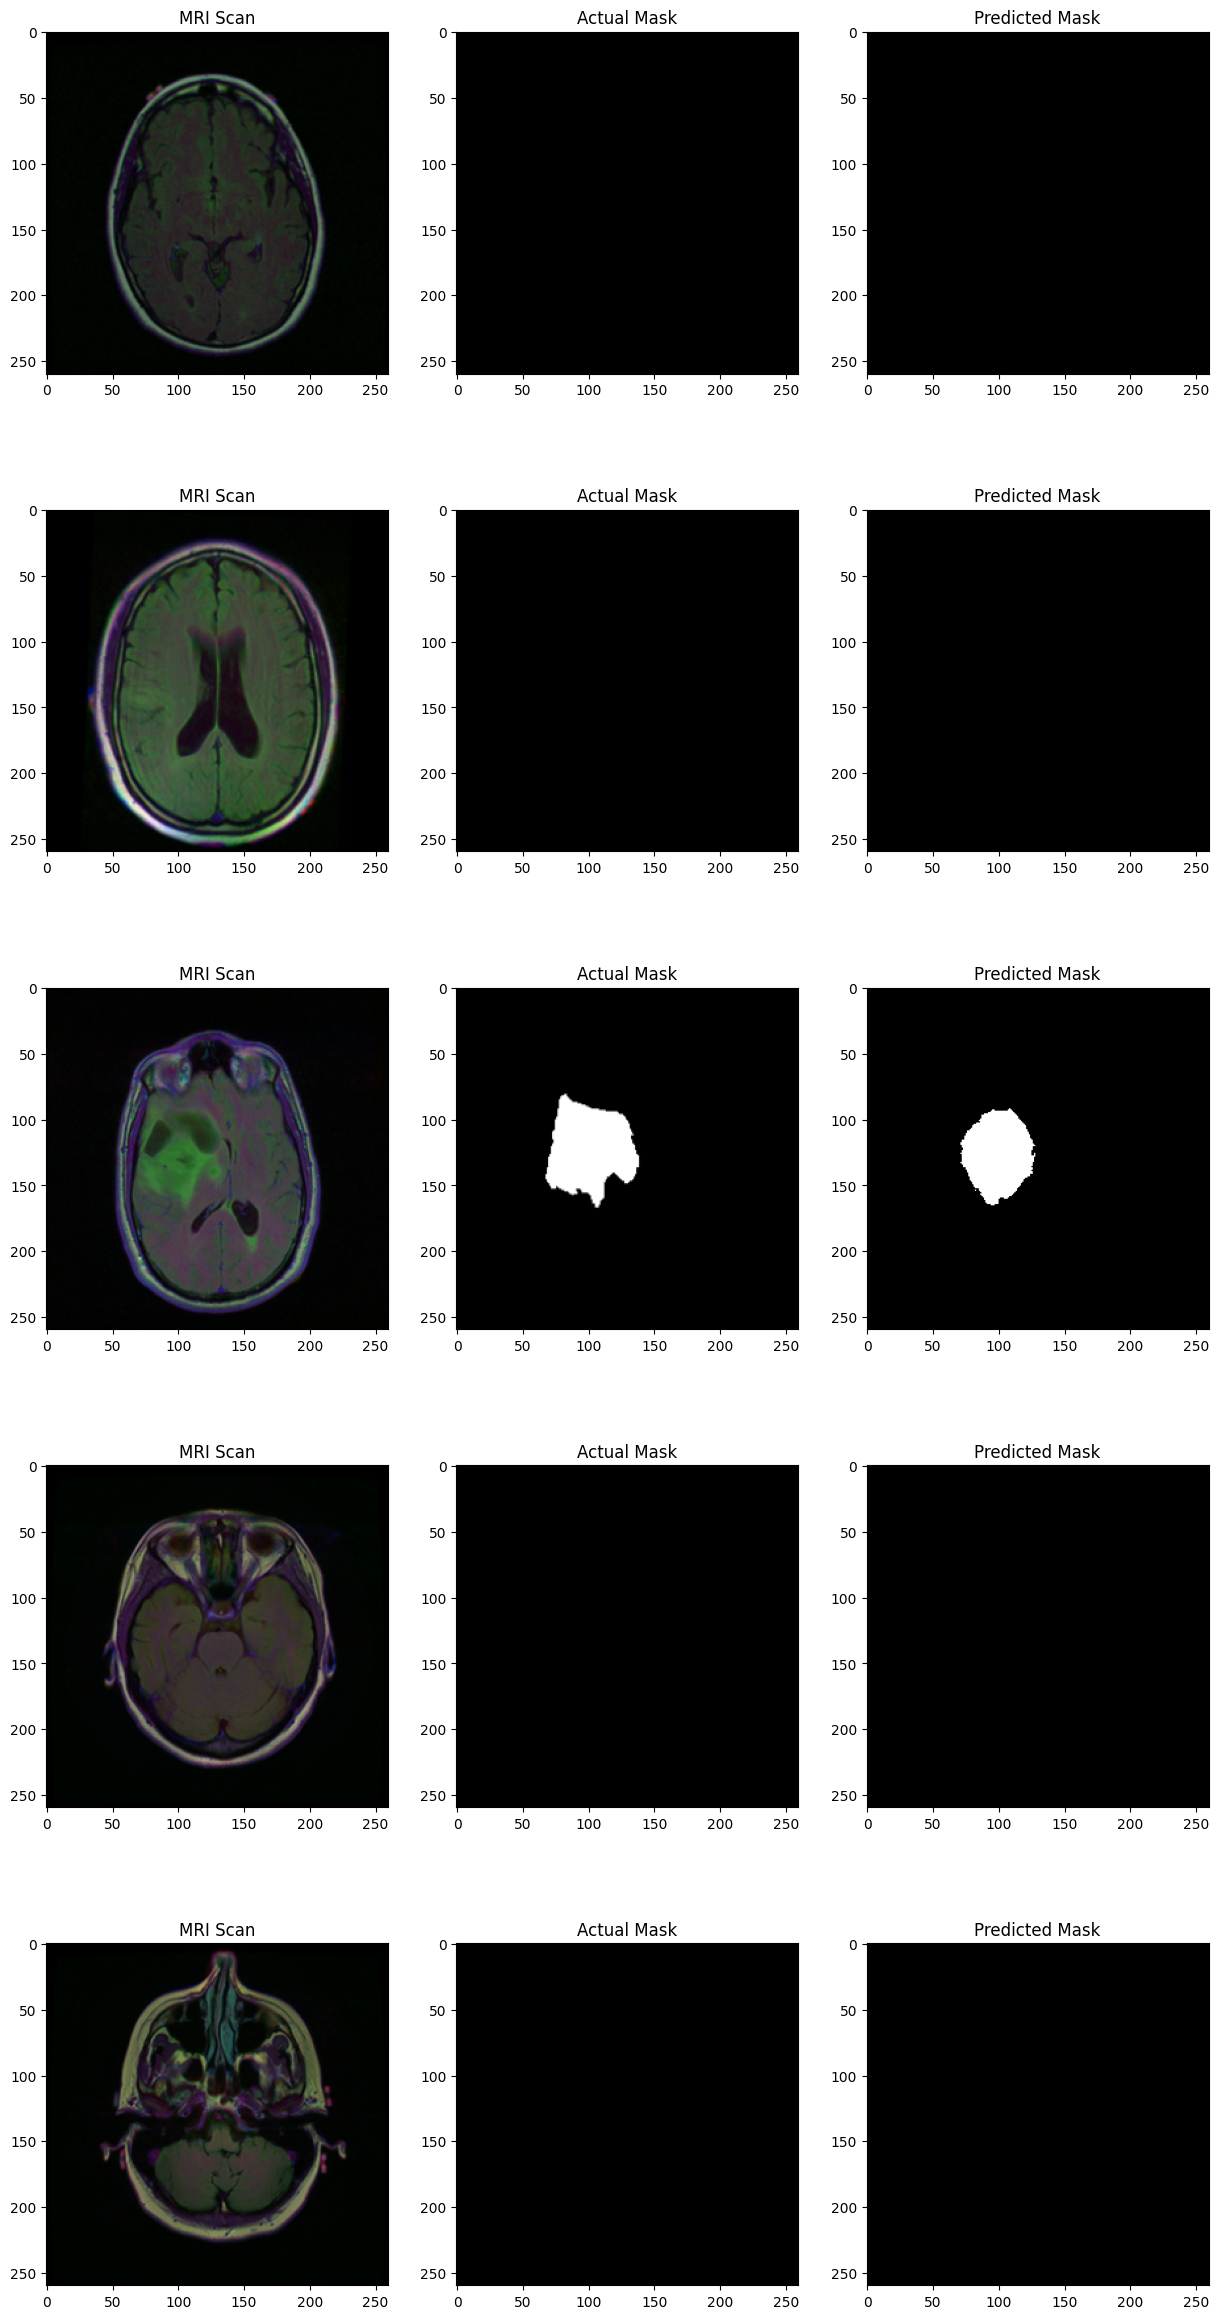

In [15]:
plot_results(model, testds, 5, 0.5, detransform=lambda x: x * std + mean, device=device)

### DenseNet

In [16]:
gc.collect()
torch.cuda.empty_cache()

In [17]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])

transforms = v2.Compose([
    v2.ToImage(),
    v2.Resize((224, 224)),
    v2.ToTensor()
])

in_transforms = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean, std)
])

out_transforms = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
])

trainds = ImageDataset(train_imgs, transforms, in_transforms, out_transforms)
valds = ImageDataset(val_imgs, transforms, in_transforms, out_transforms)
testds = ImageDataset(test_imgs, transforms, in_transforms, out_transforms)

trainloader = DataLoader(trainds, batch_size=64, shuffle=True)
valloader = DataLoader(valds, batch_size=64, shuffle=False)
testloader = DataLoader(testds, batch_size=64, shuffle=False)

In [18]:
model = models.densenet121(pretrained=True)

# for param in model.parameters():
#     param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Linear(1024, 224 * 224),
    nn.Sigmoid()
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.99))
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

num_epochs = 30

train(model, num_epochs, criterion, optimizer, trainloader, valloader, scheduler, device)
test(model, testloader, device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 211MB/s]


Epoch 1, Training Loss: 0.08824707404710352
Epoch 1, Validation Loss: 0.0351605374366045
Epoch 2, Training Loss: 0.031799389608204366
Epoch 2, Validation Loss: 0.03090774305164814
Epoch 3, Training Loss: 0.025271987006999553
Epoch 3, Validation Loss: 0.026883019879460335
Epoch 4, Training Loss: 0.01995793655514717
Epoch 4, Validation Loss: 0.019588215555995703
Epoch 5, Training Loss: 0.016499833622947335
Epoch 5, Validation Loss: 0.017146555799990894
Epoch 6, Training Loss: 0.014575654524378479
Epoch 6, Validation Loss: 0.014835964236408473
Epoch 7, Training Loss: 0.013521983393002302
Epoch 7, Validation Loss: 0.01382356956601143
Epoch 8, Training Loss: 0.012345992925111205
Epoch 8, Validation Loss: 0.012981443759053945
Epoch 9, Training Loss: 0.011249689682153985
Epoch 9, Validation Loss: 0.01229864526540041
Epoch 10, Training Loss: 0.010598286299500614
Epoch 10, Validation Loss: 0.012278212513774634
Epoch 11, Training Loss: 0.010155408934224397
Epoch 11, Validation Loss: 0.0114393778

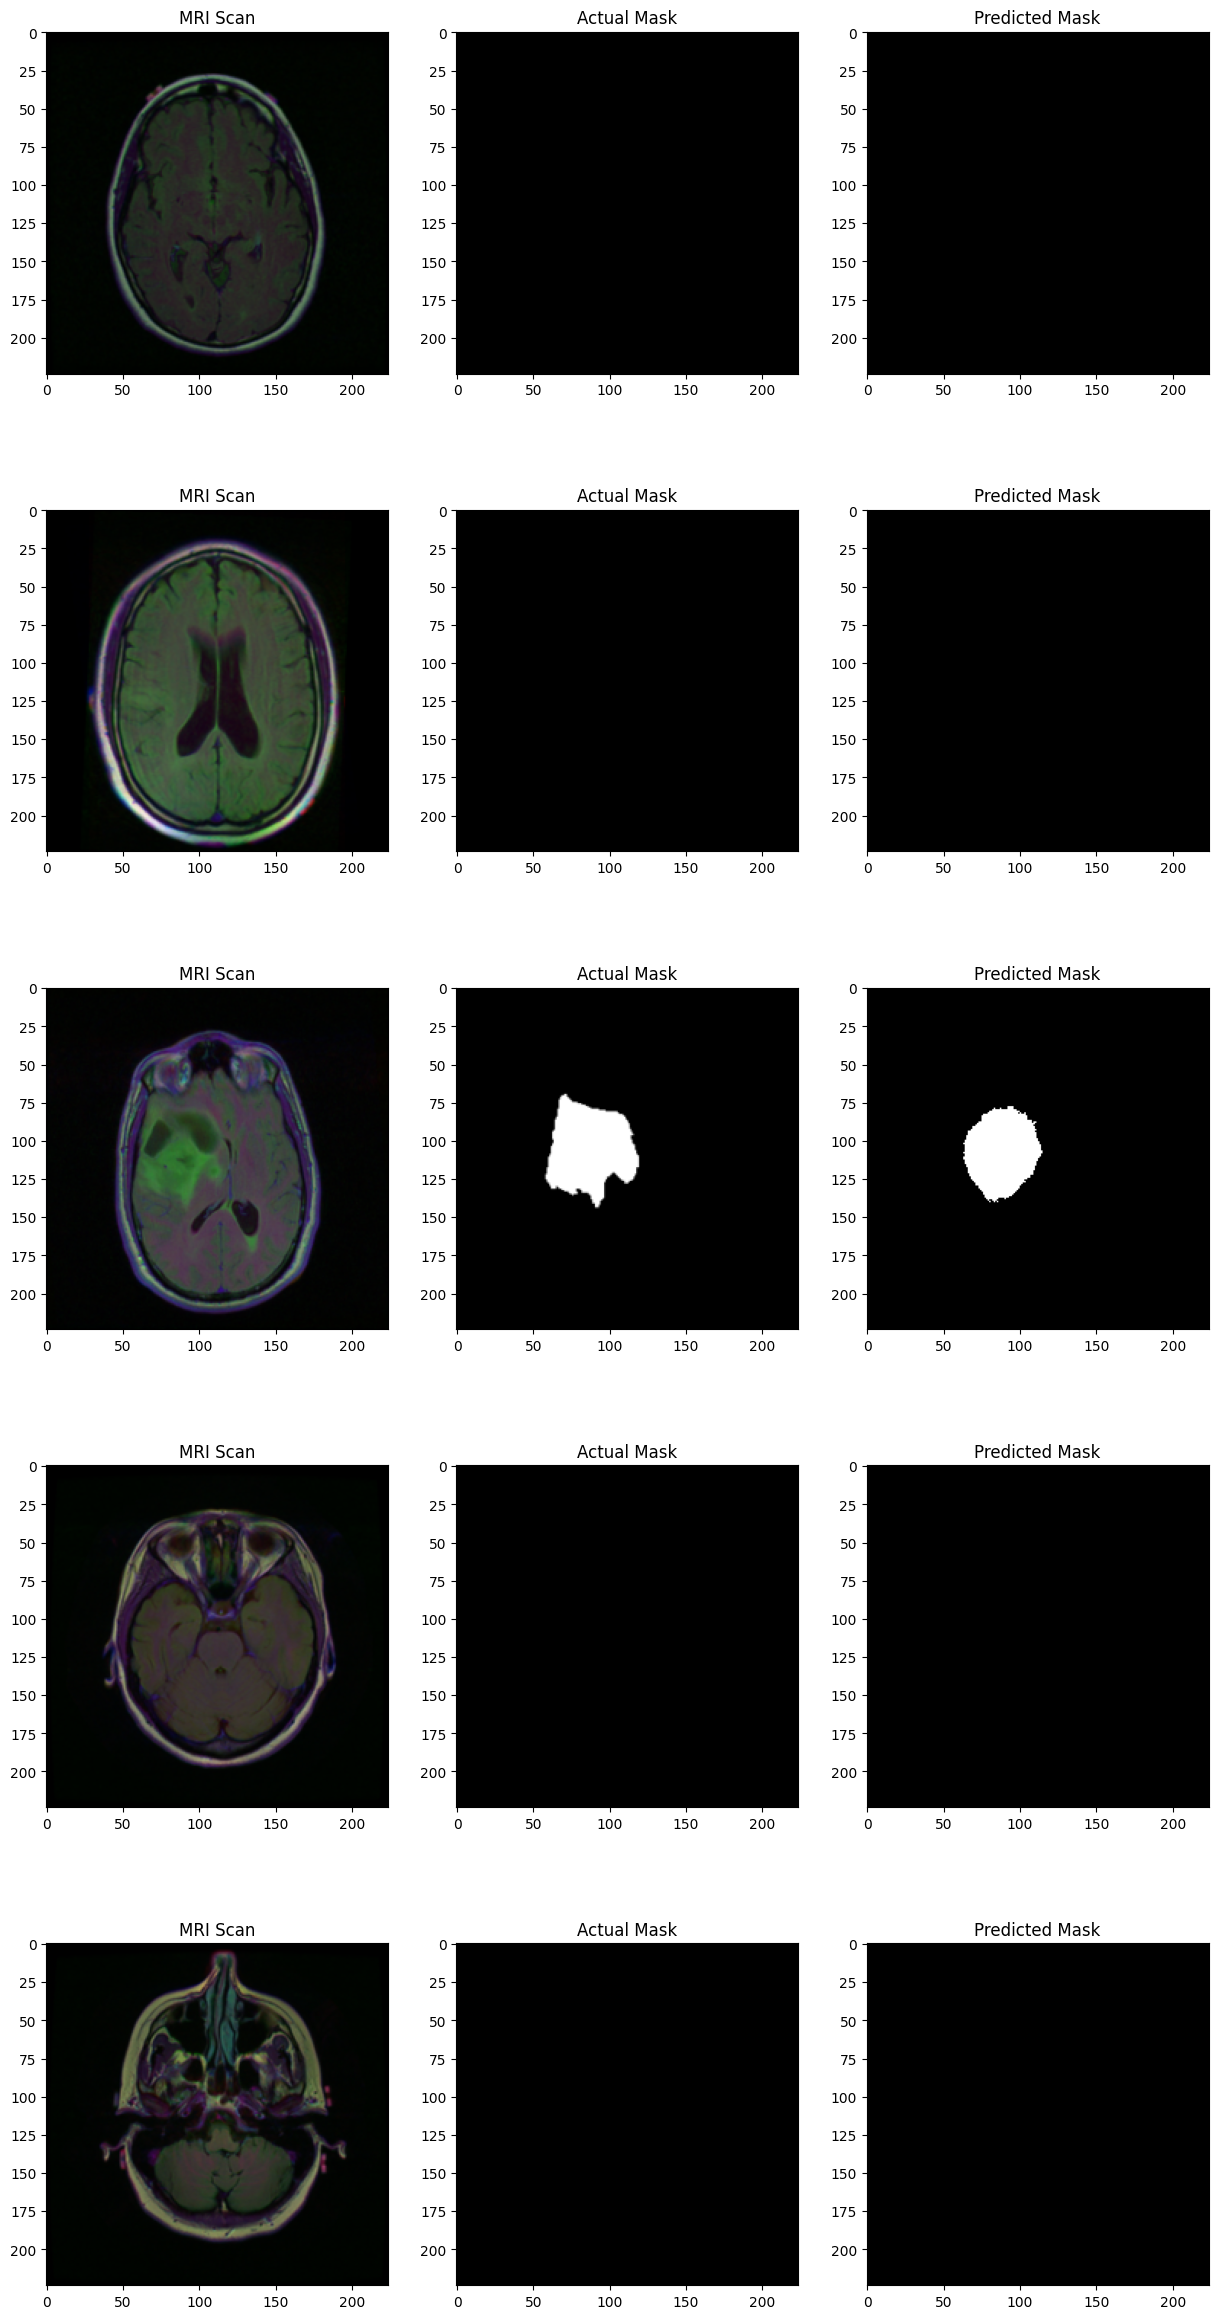

In [19]:
plot_results(model, testds, 5, 0.5, detransform=lambda x: x * std + mean, device=device)

#### ShuffleNev V2

In [20]:
gc.collect()
torch.cuda.empty_cache()

In [21]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])

transforms = v2.Compose([
    v2.ToImage(),
    v2.Resize((224, 224)),
    v2.ToTensor()
])

in_transforms = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean, std)
])

out_transforms = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
])

trainds = ImageDataset(train_imgs, transforms, in_transforms, out_transforms)
valds = ImageDataset(val_imgs, transforms, in_transforms, out_transforms)
testds = ImageDataset(test_imgs, transforms, in_transforms, out_transforms)

trainloader = DataLoader(trainds, batch_size=64, shuffle=True)
valloader = DataLoader(valds, batch_size=64, shuffle=False)
testloader = DataLoader(testds, batch_size=64, shuffle=False)

In [22]:
model = models.shufflenet_v2_x1_0(pretrained=True)

# for param in model.parameters():
#     param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(1024, 224 * 224),
    nn.Sigmoid()
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.99))
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

num_epochs = 30

train(model, num_epochs, criterion, optimizer, trainloader, valloader, scheduler, device)
test(model, testloader, device)

Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth
100%|██████████| 8.79M/8.79M [00:00<00:00, 148MB/s]


Epoch 1, Training Loss: 0.3652315059676766
Epoch 1, Validation Loss: 0.07044648379087448
Epoch 2, Training Loss: 0.06681377068161964
Epoch 2, Validation Loss: 0.04935206435620785
Epoch 3, Training Loss: 0.044836601987481114
Epoch 3, Validation Loss: 0.04280591923743486
Epoch 4, Training Loss: 0.04036090662702918
Epoch 4, Validation Loss: 0.03995478320866823
Epoch 5, Training Loss: 0.03790070656687021
Epoch 5, Validation Loss: 0.038635742478072645
Epoch 6, Training Loss: 0.036553232744336125
Epoch 6, Validation Loss: 0.037296463176608084
Epoch 7, Training Loss: 0.03509348491206765
Epoch 7, Validation Loss: 0.03618149105459452
Epoch 8, Training Loss: 0.0338268771301955
Epoch 8, Validation Loss: 0.034796723164618015
Epoch 9, Training Loss: 0.0323321096599102
Epoch 9, Validation Loss: 0.032860603928565976
Epoch 10, Training Loss: 0.030404682038351893
Epoch 10, Validation Loss: 0.030841119401156903
Epoch 11, Training Loss: 0.02883203481324017
Epoch 11, Validation Loss: 0.02948599699884653
E

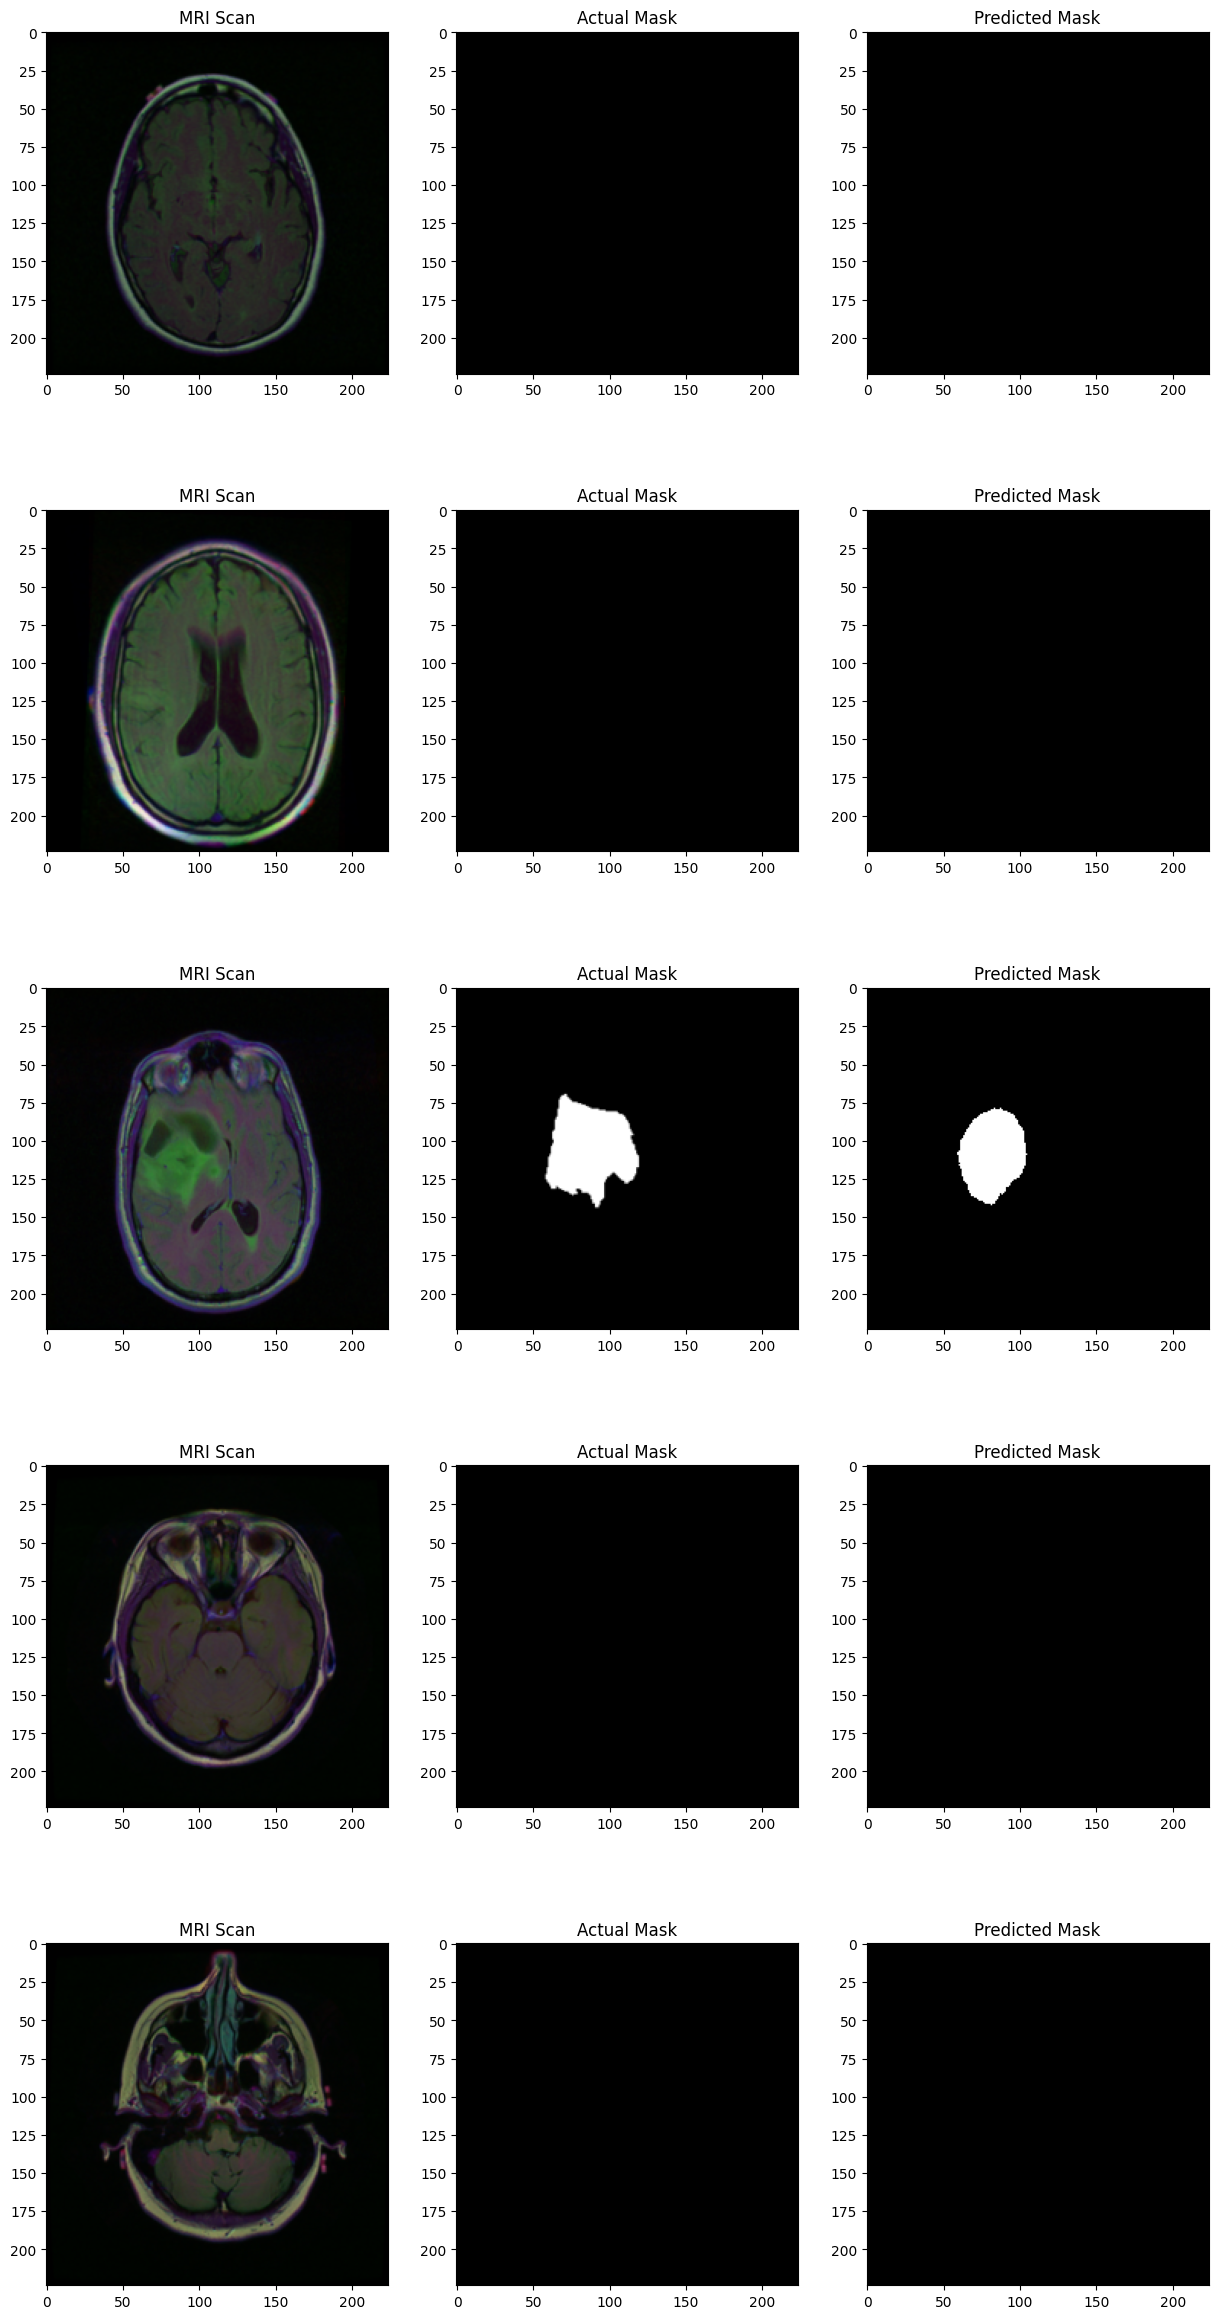

In [23]:
plot_results(model, testds, 5, 0.5, detransform=lambda x: x * std + mean, device=device)

---